# Assignment 3
**Network Science**

_Prof Reihaneh Rabbany_

Author: Albert M Orozco Camacho


# Data Processing

In [1]:
%matplotlib inline

import os
import codecs
import networkx as nx
import matplotlib.pyplot as plt

## Load Graphs

In [2]:
# Football
football_path = 'data/real-classic/football.gml'
with codecs.open(football_path, 'r') as f:
    football_raw = f.readlines()
football_raw[3] = 'multigraph 1\n'
football_graph = nx.parse_gml(football_raw, label='id')
football_graph = nx.Graph(football_graph)
football_graph.remove_edges_from(football_graph.selfloop_edges())

# Karate
karate_path = 'data/karate.gml'
karate_graph = nx.read_gml(karate_path, label='id')
karate_graph = nx.Graph(karate_graph)
karate_graph.remove_edges_from(karate_graph.selfloop_edges())

# Political blogosphere
polblogs_path = 'data/real-classic/polblogs.gml'
with codecs.open(polblogs_path, 'r') as f:
    polblogs_raw = f.readlines()
polblogs_raw[2] = 'multigraph 1\n'
polblogs_graph = nx.parse_gml(polblogs_raw, label='id')
polblogs_graph = nx.Graph(polblogs_graph)
polblogs_graph.remove_edges_from(polblogs_graph.selfloop_edges())

# Political books
polbooks_path = 'data/real-classic/polbooks.gml'
polbooks_graph = nx.read_gml(polbooks_path, label='id')
polbooks_graph = nx.Graph(polbooks_graph)
polbooks_graph.remove_edges_from(polbooks_graph.selfloop_edges())

# Strike
strike_path = 'data/real-classic/strike.gml'
strike_graph = nx.read_gml(strike_path, label='id')
strike_graph = nx.Graph(strike_graph)
strike_graph.remove_edges_from(strike_graph.selfloop_edges())

# Apply Algorithms

In [8]:
import os
import codecs
import igraph as ig
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [9]:
def apply_evaluate(graph_,
                   label_name='value',
                   delete_range=range(95, 15, -10),
                   runs=10, save=False):
    y_true = [n[label_name] for _, n in graph_.nodes(data=True)]
    results = pd.DataFrame({'run': [], 'deleted_nodes': [], 'harmnc': [], 'lgcnc': []})
    mean_results = pd.DataFrame({'run': [], 'harmnc_avg': [], 'lgcnc_avg': []})
    
    for run in range(runs):
        for offset in delete_range:
            # Delete % of nodes values to predict
            graph = graph_.copy()
            nodes = graph.nodes(data=True)
            for _, node in nodes:
                if np.random.rand() > offset / 100:
                    del node[label_name]

            # Harmonic Function
            harm_nc = nx.algorithms.node_classification.hmn.harmonic_function(graph, label_name=label_name)
            harm_nc_acc = accuracy_score(y_true, harm_nc)       
    
            # Local and Global Consistency
            lgc_nc = nx.algorithms.node_classification.lgc.local_and_global_consistency(graph, label_name=label_name)
            lgc_nc_acc = accuracy_score(y_true, lgc_nc)
        
            results = results.append({'run': run + 1,
                                      'deleted_nodes': offset / 100,
                                      'harmnc': harm_nc_acc,
                                      'lgcnc': lgc_nc_acc}, ignore_index=True)
        harmnc_avg = results.loc[run]['harmnc'].mean()
        lgcnc_avg = results.loc[run]['lgcnc'].mean()
        mean_results = mean_results.append({'run': run + 1,
                                            'harmnc_avg': harmnc_avg,
                                            'lgcnc_avg': lgcnc_avg}, ignore_index=True)
        
    mean_results.set_index(['run'], inplace=True)
    ax = mean_results.plot()
    fig = ax.get_figure()
    if save:
        fig.savefig(save)
    return mean_results

In [16]:
def apply_evaluate_lp(graph_, runs=10, save=False):
    results = pd.DataFrame({'run': [],
                            'resource_allocation_index': [],
                            'jaccard_coefficient': [],
                            'preferential_attachment': []})
    for run in tqdm(range(runs)):
        # Delete 20% of edges to predict
        graph = graph_.copy()
        edges = list(graph.edges())
        removed = []
        coins = np.random.rand(len(edges)) < 0.2
        for i, coin in enumerate(coins):
            if coin:
                edge = edges[i]
                graph.remove_edge(edge[0], edge[1])
                removed.append(edge)

        # resource_allocation_index
        rai = list(nx.resource_allocation_index(graph))
        y_true = np.zeros(len(rai), dtype=np.int)
        for edge in edges:
            for i, r in enumerate(rai):
                if edge[0] == r[0] and edge[1] == r[1] or\
                   edge[1] == r[0] and edge[0] == r[1]:
                    y_true[i] = 1
        y_pred = [yp for _, _, yp in rai]
        rai_auc = roc_auc_score(y_true, y_pred)
        
        # jaccard_coefficient
        jc = list(nx.jaccard_coefficient(graph))
        y_true = np.zeros(len(jc), dtype=np.int)
        for edge in edges:
            for i, r in enumerate(jc):
                if edge[0] == r[0] and edge[1] == r[1] or\
                   edge[1] == r[0] and edge[0] == r[1]:
                    y_true[i] = 1
        y_pred = [yp for _, _, yp in jc]
        jc_auc = roc_auc_score(y_true, y_pred)
        
        # preferential_attachment
        pa = list(nx.preferential_attachment(graph))
        y_true = np.zeros(len(pa), dtype=np.int)
        for edge in edges:
            for i, r in enumerate(pa):
                if edge[0] == r[0] and edge[1] == r[1] or\
                   edge[1] == r[0] and edge[0] == r[1]:
                    y_true[i] = 1
        y_pred = [yp for _, _, yp in pa]
        pa_auc = roc_auc_score(y_true, y_pred)
        
        results = results.append({'run': run + 1,
                                  'resource_allocation_index': rai_auc,
                                  'jaccard_coefficient': jc_auc,
                                  'preferential_attachment': pa_auc},
                                 ignore_index=True)
        
    results.set_index(['run'], inplace=True)
    ax = results.plot()
    fig = ax.get_figure()
    if save:
        fig.savefig(save)
    return results

Football


,harmnc_avg,lgcnc_avg
run,,
1.0,0.973913,0.895652
2.0,0.947826,0.886957
3.0,0.956522,0.886957
4.0,0.973913,0.886957
5.0,0.965217,0.826087
6.0,0.921739,0.817391
7.0,0.921739,0.721739
8.0,0.930435,0.878261
9.0,0.991304,0.913043


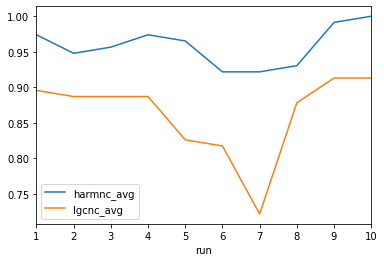

In [60]:
# Football
print('Football')
apply_evaluate(football_graph, save='football.png')

Football


resource_allocation_index    0.824434
jaccard_coefficient          0.834562
preferential_attachment      0.319638
dtype: float64

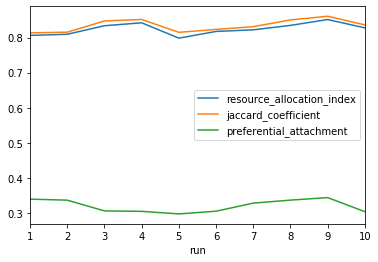

In [31]:
# Football
print('Football')
apply_evaluate_lp(football_graph, save='football-lp.png').mean()

Karate


,harmnc_avg,lgcnc_avg
run,,
1.0,1.000000,0.970588
2.0,1.000000,0.970588
3.0,1.000000,0.970588
4.0,1.000000,1.000000
5.0,0.970588,0.882353
6.0,0.911765,0.617647
7.0,0.970588,1.000000
8.0,0.970588,1.000000
9.0,1.000000,1.000000


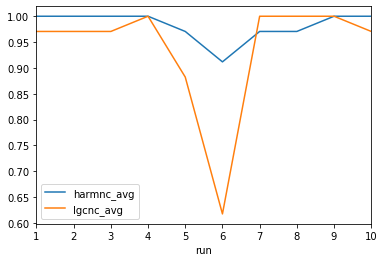

In [61]:
# Karate
print('Karate')
apply_evaluate(karate_graph, save='karate.png')

Karate


resource_allocation_index    0.710052
jaccard_coefficient          0.610875
preferential_attachment      0.702046
dtype: float64

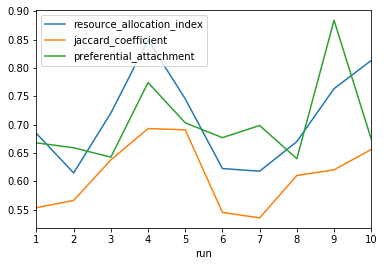

In [32]:
# Karate
print('Karate')
apply_evaluate_lp(karate_graph, save='karate-lp.png').mean()

Polblogs


,harmnc_avg,lgcnc_avg
run,,
1.0,0.995973,0.975168
2.0,0.987919,0.969799
3.0,0.973154,0.959060
4.0,0.965772,0.954362
5.0,0.957047,0.951007
6.0,0.942953,0.934899
7.0,0.936242,0.930872
8.0,0.918792,0.916779
9.0,0.993960,0.972483


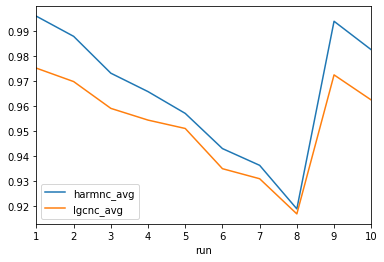

In [62]:
# Polblogs
print('Polblogs')
apply_evaluate(polblogs_graph, save='polblogs.png')

In [13]:
# Polblogs
print('Polblogs')
apply_evaluate_lp(polblogs_graph, save='polblogs-lp.png').mean()

  0%|          | 0/10 [00:00<?, ?it/s]

Polblogs


KeyboardInterrupt: 

Polbooks


,harmnc_avg,lgcnc_avg
run,,
1.0,0.980952,0.866667
2.0,0.952381,0.866667
3.0,0.961905,0.866667
4.0,0.942857,0.857143
5.0,0.914286,0.876190
6.0,0.933333,0.857143
7.0,0.904762,0.895238
8.0,0.866667,0.866667
9.0,1.000000,0.866667


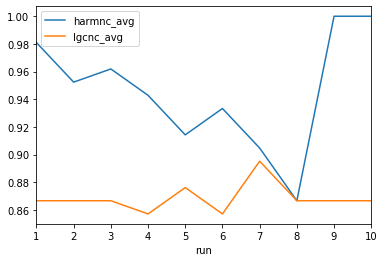

In [63]:
# Polbooks
print('Polbooks')
apply_evaluate(polbooks_graph, save='polbooks.png')

Polbooks


resource_allocation_index    0.872320
jaccard_coefficient          0.851827
preferential_attachment      0.662515
dtype: float64

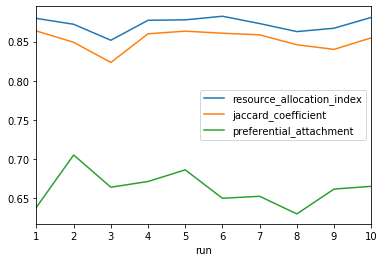

In [35]:
# Polbooks
print('Polbooks')
apply_evaluate_lp(polbooks_graph, save='polbooks-lp.png').mean()

Strike


,harmnc_avg,lgcnc_avg
run,,
1.0,1.000000,1.000000
2.0,1.000000,1.000000
3.0,1.000000,1.000000
4.0,1.000000,0.916667
5.0,1.000000,1.000000
6.0,0.958333,0.916667
7.0,0.958333,0.875000
8.0,0.791667,0.791667
9.0,1.000000,1.000000


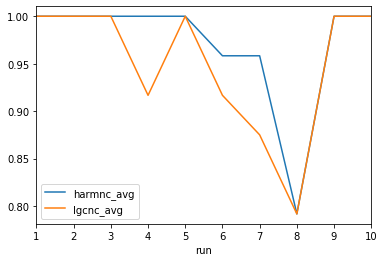

In [64]:
# Strike
print('Strike')
apply_evaluate(strike_graph, save='strike.png')


100%|██████████| 10/10 [00:00<00:00, 79.09it/s][A

Strike


resource_allocation_index    0.711585
jaccard_coefficient          0.714383
preferential_attachment      0.425176
dtype: float64

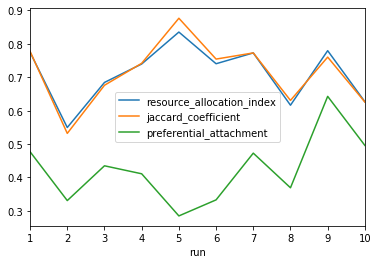

In [17]:
# Strike
print('Strike')
apply_evaluate_lp(strike_graph, save='strike-lp.png').mean()

## Real-Node-Label

In [18]:
import os
import sys
import pickle as pkl
import numpy as np
import scipy.sparse as sp

from utils import parse_index_file, sample_mask

In [19]:
def load_data(dataset_str,
              data_path='data/gcn'):
    """
    Loads input data from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    Taken from https://github.com/tkipf/gcn/blob/master/gcn/utils.py#L24
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open(os.path.join(data_path, "ind.{}.{}".format(dataset_str, names[i])), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(os.path.join(data_path, "ind.{}.test.index".format(dataset_str)))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    
    return adj, labels

### Citeseer

In [20]:
citeseer_adj, citeseer_y_train = load_data('citeseer')
citeseer_adj = citeseer_adj.toarray()
citeseer_graph = nx.from_numpy_matrix(citeseer_adj)

In [21]:
citeseer_nodes = citeseer_graph.nodes(data=True)
for i, y in enumerate(citeseer_y_train):
    citeseer_nodes[i]['value'] = np.argmax(y)

,harmnc_avg,lgcnc_avg
run,,
1.0,0.987075,0.838293
2.0,0.958521,0.827773
3.0,0.925759,0.806733
4.0,0.889991,0.800421
5.0,0.852720,0.783889
6.0,0.810340,0.758641
7.0,0.771867,0.739705
8.0,0.712955,0.700631
9.0,0.986474,0.834085


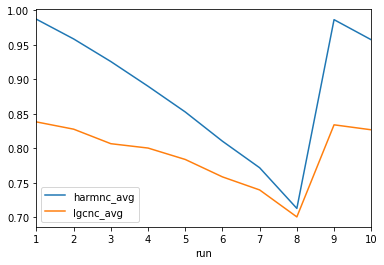

In [69]:
apply_evaluate(citeseer_graph, save='citeseer.png')

In [22]:
# Citeseer
print('Citeseer')
apply_evaluate_lp(citeseer_graph, save='citeseer-lp.png').mean()


  0%|          | 0/10 [00:00<?, ?it/s]

Citeseer


KeyboardInterrupt: 

### Cora

In [70]:
cora_adj, cora_y_train = load_data('cora')
cora_adj = cora_adj.toarray()
cora_graph = nx.from_numpy_matrix(cora_adj)

In [71]:
cora_nodes = cora_graph.nodes(data=True)
for i, y in enumerate(cora_y_train):
    cora_nodes[i]['value'] = np.argmax(y)

,harmnc_avg,lgcnc_avg
run,,
1.0,0.991507,0.912482
2.0,0.982275,0.909897
3.0,0.964549,0.906204
4.0,0.942024,0.892171
5.0,0.931315,0.897341
6.0,0.915436,0.883309
7.0,0.889956,0.874077
8.0,0.849335,0.847858
9.0,0.994092,0.911004


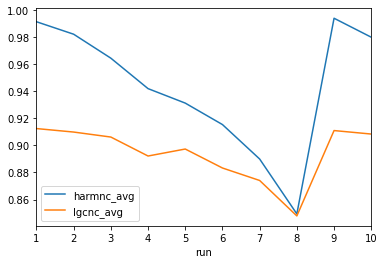

In [72]:
apply_evaluate(cora_graph, save='cora.png')

### Pubmed

In [28]:
pubmed_adj, pubmed_y_train = load_data('pubmed')
pubmed_adj = pubmed_adj.toarray()
pubmed_graph = nx.from_numpy_matrix(pubmed_adj)

In [29]:
pubmed_nodes = pubmed_graph.nodes(data=True)
for i, y in enumerate(pubmed_y_train):
    pubmed_nodes[i]['value'] = np.argmax(y)

,harmnc_avg,lgcnc_avg
run,,
1.0,0.991124,0.856165
2.0,0.971750,0.854897
3.0,0.955115,0.852970
4.0,0.934676,0.853325
5.0,0.919663,0.855556
6.0,0.903586,0.852817
7.0,0.884567,0.851854
8.0,0.865750,0.844398
9.0,0.991581,0.855556


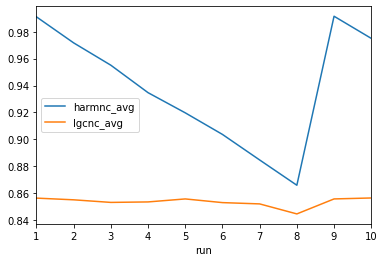

In [30]:
apply_evaluate(pubmed_graph)

## Synthetic

In [23]:
from networkx.algorithms.community.community_generators import LFR_benchmark_graph
from sklearn.preprocessing import OneHotEncoder

In [ ]:
for mu in range(10, 90, 10):
    n = 1000 #@param {type:"slider", min:1, max:2000}
    tau1 = 3 #@param {type:"slider", min:1.1, max:10, step:0.01}
    tau2 = 1.5 #@param {type:"slider", min:1.1, max:10, step:0.01}
    average_degree = 10 #@param {type:"slider", min:0, max:143}
    min_community = 20 #@param {type:"integer"}
    lfr_graph = LFR_benchmark_graph(n, tau1, tau2, mu / 100,
                                    average_degree=average_degree,
                                    min_community=min_community)
    comms = [n['community'] for _, n in lfr_graph.nodes(data=True)]
    lfr_nodes = lfr_graph.nodes(data=True)
    for i, y in enumerate(comms):
        lfr_nodes[i]['value'] = str(y)
    apply_evaluate_lp(lfr_graph, save='lfr-{}-lp.png'.format(mu))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [15:32<2:19:48, 932.09s/it]

 20%|██        | 2/10 [31:07<2:04:25, 933.19s/it]

 30%|███       | 3/10 [46:46<1:49:04, 934.87s/it]

 40%|████      | 4/10 [1:02:16<1:33:20, 933.44s/it]

In [21]:
comms = [n['community'] for _, n in lfr_graph.nodes(data=True)]
lfr_nodes = lfr_graph.nodes(data=True)
for i, y in enumerate(comms):
    lfr_nodes[i]['value'] = str(y)

In [20]:
maximum = max(map(max, comms))
for c in comms:
    lfr_nodes[c]['value'] = 

999

,harmnc_avg,lgcnc_avg
run,,
1.0,1.000,1.000
2.0,1.000,1.000
3.0,0.999,0.997
4.0,1.000,0.999
5.0,0.998,0.994
6.0,0.999,0.995
7.0,0.997,0.989
8.0,0.993,0.956
9.0,1.000,1.000


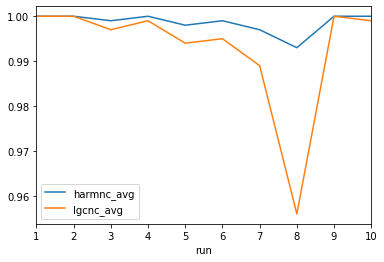

In [22]:
apply_evaluate(lfr_graph, save='lfr-{}.png'.format(mu))

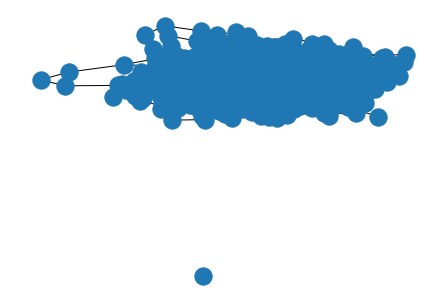

In [34]:

#nx.write_graphml(lfr_graph, 'lfr_graph.graphml')
#lfr_graph = nx.read_gml('lfr_graph.graphml')
#lfr_igraph = ig.read('lfr_graph.graphml', format='graphml')
lfr_adj = nx.adjacency_matrix(lfr_graph).toarray()
lfr_igraph = ig.Graph.Adjacency((lfr_adj > 0).tolist())

nx.draw(lfr_graph)
plt.show()